In [1]:
#!pip install --upgrade botocore==1.23.26
#!pip install --upgrade urllib3==1.22.0
#!pip install py7zr
#!pip install s3fs
#!git clone https://github.com/InseeFrLab/cartogether.git
#%cd ./cartogether
#!pip install -r requirements.txt
#!pip install .
#!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#!pip install git+https://github.com/inseefrlab/cartogether
#!pip install pandas fiona shapely pyproj rtree
#!pip install contextily
#!pip install geopandas
#!pip install pygeos
#!pip install geopy
#!pip install pynsee[full]

In [41]:
import contextily as ctx
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

In [42]:
import pynsee
from pynsee.utils.init_conn import init_conn

N=100000

init_conn(insee_key="k32RC1ZJH8RV4Llh6kTRakU15tca", insee_secret="CTnVGRLchI7dbJOlrvYbrOyIfnMa")
data = pynsee.search_sirene(variable = ["activitePrincipaleEtablissement"],
                       pattern = "10.82Z", kind = 'siret', number=N)

data = data.loc[data['dateFin'].isnull()]
df=data[["activitePrincipaleEtablissement","typeVoieEtablissement","libelleVoieEtablissement","libelleCommuneEtablissement","codePostalEtablissement"]]

Token has been created
!!! Please subscribe to BDM API on api.insee.fr !!!
!!! Please subscribe to Metadata API on api.insee.fr !!!
!!! Please subscribe to Local Data API on api.insee.fr !!!


5/100 - Getting data: 100%|██████████| 661/661 [00:04<00:00, 163.50it/s]


6/100 - No more data found
7/100 - No more data found
Data saved: /home/onyxia/.cache/pynsee/pynsee/67c6deb653557b58d7da5914e7560392


In [43]:
df=df.dropna()
liste_departements=["75","77","78","91","92","93","94","95"]
department=[]
for ville in df.codePostalEtablissement:
    department.append(ville[:2])
df['departement']=department
df=df[df.activitePrincipaleEtablissement=="10.82Z"]
df=df[df.departement.isin(liste_departements)]
df

,activitePrincipaleEtablissement,typeVoieEtablissement,libelleVoieEtablissement,libelleCommuneEtablissement,codePostalEtablissement,departement
15,10.82Z,RUE,GUSTAVE EIFFEL,MORANGIS,91420,91
17,10.82Z,IMP,DE BAYENVILLES,GUERVILLE,78930,78
32,10.82Z,RUE,DE L'EGLISE,VETHEUIL,95510,95
41,10.82Z,RUE,J B SEMANAZ,LE PRE-SAINT-GERVAIS,93310,93
42,10.82Z,RUE,DE BELLEVILLE,PARIS 20,75020,75
...,...,...,...,...,...,...
2674,10.82Z,RUE,ABEL,PARIS 12,75012,75
2676,10.82Z,RUE,BLANCHARD,FONTENAY-AUX-ROSES,92260,92
2685,10.82Z,RUE,JACQUES HENRI LARTIGUE,ISSY-LES-MOULINEAUX,92130,92
2691,10.82Z,PL,DE LA MAIRIE,ORGEVAL,78630,78


In [44]:
def get_location(adress):
    geolocator = Nominatim(user_agent="tutorial")
    location = geolocator.geocode(adress)
    return((location.latitude, location.longitude))

def get_location_all(commerces):
    commerces["typeVoieEtablissement"] = commerces["typeVoieEtablissement"].map({"RUE": "rue", "AV": "avenue", "CHS": "chaussée", "CHE": "chemin", "PL": "place", "HAM": "hameau", "BD": "boulevard", "QUAI": "quai", "ALL": "allée"})
    geom = []
    liste_long=[]
    liste_lat=[]
    for k in range(len(commerces)):
        print(k)
        try:
            type_voie, libelle_voie, commune = commerces.iloc[k,1], commerces.iloc[k,2], commerces.iloc[k,3]
            loc1,loc2=get_location(f"{type_voie} {libelle_voie} {commune}")
            geom.append(Point(loc1,loc2))
            liste_long.append(loc2)
            liste_lat.append(loc1)
        except Exception:
            commerces=commerces.drop(df.index[k])
    commerces = commerces.set_geometry(geom)
    commerces['long']=liste_long
    commerces['lat']=liste_lat
    return(commerces)

In [45]:
df=get_location_all(df)
df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,activitePrincipaleEtablissement,typeVoieEtablissement,libelleVoieEtablissement,libelleCommuneEtablissement,codePostalEtablissement,departement,geometry,long,lat
15,10.82Z,rue,GUSTAVE EIFFEL,MORANGIS,91420,91,POINT (48.69987 2.34005),2.340052,48.699874
41,10.82Z,rue,J B SEMANAZ,LE PRE-SAINT-GERVAIS,93310,93,POINT (48.86045 2.44105),2.441048,48.860446
42,10.82Z,rue,DE BELLEVILLE,PARIS 20,75020,75,POINT (48.74632 2.50777),2.507767,48.746316
43,10.82Z,rue,DU CAPITAINE DREYFUS,MONTREUIL,93100,93,POINT (48.99700 2.29525),2.295248,48.996998
57,10.82Z,rue,DE LA PROCESSION,BOISSY-SAINT-LEGER,94470,94,POINT (48.87537 2.32640),2.326400,48.875368
...,...,...,...,...,...,...,...,...,...
2424,10.82Z,rue,DU CHAMP DE MARS,PARIS 7,75007,75,POINT (48.92828 2.47528),2.475278,48.928277
2426,10.82Z,chemin,DE SAINT GUNIFORT,COULOMBS-EN-VALOIS,77840,77,POINT (48.18977 2.72779),2.727786,48.189768
2452,10.82Z,rue,DU MAINE,CHAMPIGNY-SUR-MARNE,94500,94,POINT (48.69170 2.62019),2.620191,48.691702
2464,10.82Z,boulevard,VICTOR HUGO,POISSY,78300,78,POINT (48.79546 2.28996),2.289960,48.795457


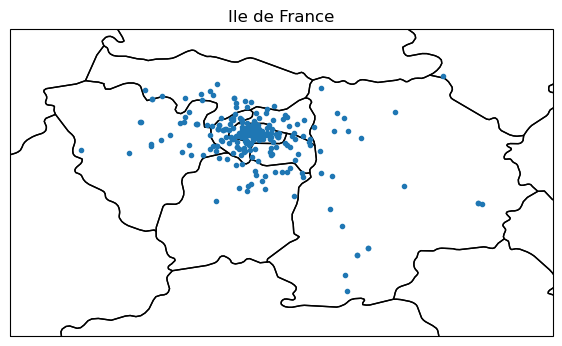

In [46]:
#!pip install cartopy

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([1.3, 3.6, 48, 49.3])

ax.add_feature(cfeature.STATES)
ax.plot(df.long, df.lat, '.')
ax.set_title('Ile de France');

In [47]:
#df.to_csv("chocolateries.csv", encoding='utf-8', index=False)

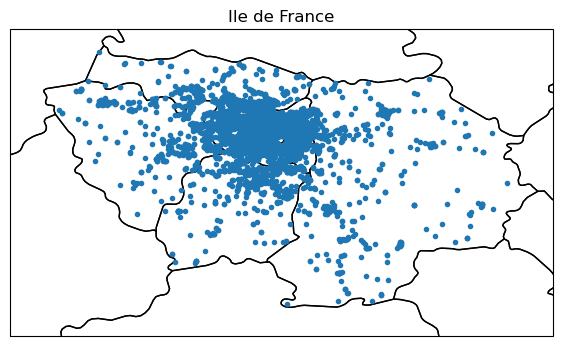

In [25]:
df=pd.read_csv("Projet-2A/boulangerie.csv")
%matplotlib inline
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([1.3, 3.6, 48, 49.3])

ax.add_feature(cfeature.STATES)
ax.plot(df.long, df.lat, '.')
ax.set_title('Ile de France');

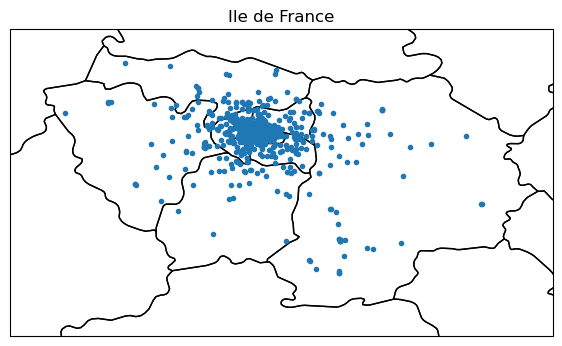

In [40]:
df=pd.read_csv("Projet-2A/librairies.csv")
%matplotlib inline
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([1.3, 3.6, 48, 49.3])

ax.add_feature(cfeature.STATES)
ax.plot(df.long, df.lat, '.')
ax.set_title('Ile de France');

In [ ]:
"Education"